In [4]:
#If needed
#!pip install tensorflow -q
#!pip install ipycanvas -q
#!pip install opencv-python -q
#!pip install python-doctr[tensorflow] -q
#!pip install tensorflow-addons -q
#!pip install pybind11 -q
#!pip install fastwer -q

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import json
import fastwer
import string
import cv2

from modules.pym_dataframe import get_clean_dataframe, get_test_dataframe
from modules.pym_image_preprocessing import preprocess
from modules.pym_crnn import ctc_loss, build_crnn
from modules.pym_encoding import encode_labels, greedy_decoder
from modules.pym_drawing_reader import PymDrawingReader

imgSize = (32, 128)

In [2]:

model = tf.keras.models.load_model('./models/cnn_rnn_20.h5', compile=False)
model.summary()

C:\Users\ybeil\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: modules.pym_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 128, 32)       832       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 128, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_11 (Bat  (None, 16, 64, 64)      

In [2]:
def build_eval_file(X, y, model_name_path_start, char_list = list(string.printable)):
    evals = []

    truth = list(map(lambda x: x.decode("utf-8") , y.numpy()))

    for i in range(1,21):
        history_json_name = model_name_path_start + str(i)+ '.json'

        # get loss and val_loss from history file
        with open(history_json_name) as f:
            history = json.load(f)
        loss = history['loss'][0]
        val_loss = history['val_loss'][0]

        # build cer
        model_name = model_name_path_start + str(i)+ '.h5'
        model = tf.keras.models.load_model(model_name, compile=False)   
        pred = greedy_decoder(model(X), char_list)
        cer = fastwer.score(pred, truth, char_level=True)

        evals.append({'loss' : loss, 'val_loss' : val_loss, 'cer' : cer})  

    # Save evals
    eval_file_name = model_name_path_start + 'evals.json'
    with open(eval_file_name, 'w') as fout:
        json.dump(evals, fout)

In [4]:
# gather loss, val_loss and cer for the model built on all characters
df = get_clean_dataframe()
# Take the same random seed than the one used for training the model so that we use the real test set
X_train_path, X_test_path, y_train, y_test = train_test_split(df.path, df.transcription_word, train_size=0.9, random_state=1234)
dataset = tf.data.Dataset.from_tensor_slices((X_test_path,y_test))
dataset = dataset.map(lambda x, y : [preprocess(x, imgSize, scale=0.8), y]).batch(len(X_test_path))
X, y = next(iter(dataset))
build_eval_file(X,y,'./models/cnn_rnn_')

C:\Users\ybeil\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: modules.pym_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [5]:
# Do the same on model built on lowercase letters
df = get_clean_dataframe(lowercase_only=True)
# Take the same random seed than the one used for training the model so that we use the real test set
X_train_path, X_test_path, y_train, y_test = train_test_split(df.path, df.transcription_word, train_size=0.9, random_state=1234)
dataset = tf.data.Dataset.from_tensor_slices((X_test_path,y_test))
dataset = dataset.map(lambda x, y : [preprocess(x, imgSize, scale=0.8), y]).batch(len(X_test_path))
X, y = next(iter(dataset))
build_eval_file(X,y,'./models/cnn_rnn_lowercase_', list(string.ascii_lowercase))

C:\Users\ybeil\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: modules.pym_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


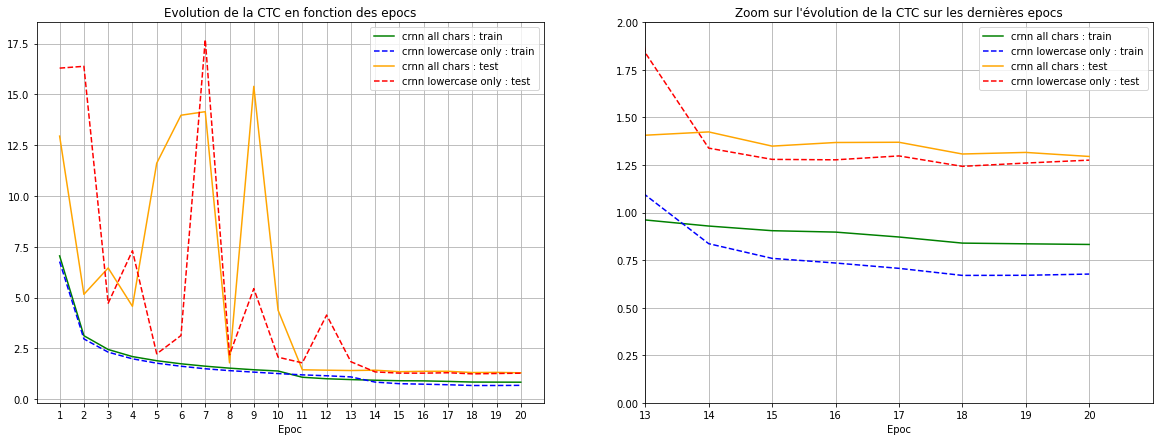

In [6]:
with open('./models/cnn_rnn_evals.json') as f:
    crnn_evals = json.load(f)
with open('./models/cnn_rnn_lowercase_evals.json') as f:
    crnn_lowercase_evals = json.load(f)
epocs = np.arange(1,21)

crnn_val_per_metric = {k: [dic[k] for dic in crnn_evals] for k in crnn_evals[0]}
crnn_lowercase_val_per_metric = {k: [dic[k] for dic in crnn_lowercase_evals] for k in crnn_lowercase_evals[0]}

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.xlabel('Epoc')
plt.title('Evolution de la CTC en fonction des epocs')
plt.grid(True)
plt.xticks(epocs)
plt.plot(epocs, crnn_val_per_metric['loss'], label="crnn all chars : train", c="green" )
plt.plot(epocs, crnn_lowercase_val_per_metric['loss'], label="crnn lowercase only : train", c="blue" , linestyle='--')
plt.plot(epocs, crnn_val_per_metric['val_loss'], label="crnn all chars : test", c="orange")
plt.plot(epocs, crnn_lowercase_val_per_metric['val_loss'], label="crnn lowercase only : test", c="red" , linestyle='--')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoc')
plt.title('Zoom sur l\'évolution de la CTC sur les dernières epocs')
plt.grid(True)
plt.xticks(epocs)
plt.plot(epocs, crnn_val_per_metric['loss'], label="crnn all chars : train", c="green" )
plt.plot(epocs, crnn_lowercase_val_per_metric['loss'], label="crnn lowercase only : train", c="blue" , linestyle='--')
plt.plot(epocs, crnn_val_per_metric['val_loss'], label="crnn all chars : test", c="orange")
plt.plot(epocs, crnn_lowercase_val_per_metric['val_loss'], label="crnn lowercase only : test", c="red" , linestyle='--')
plt.xlim(13,21)
plt.ylim(0,2)
plt.legend()

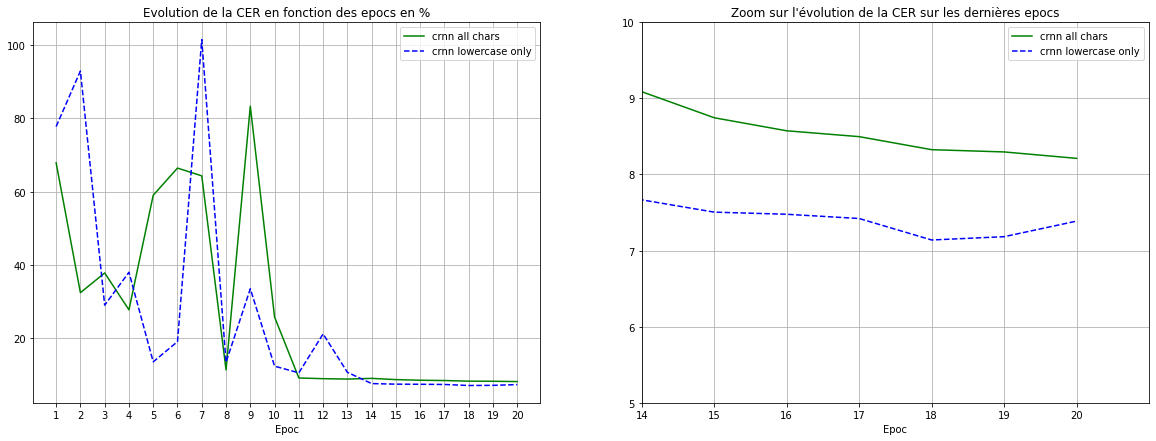

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.xlabel('Epoc')
plt.title('Evolution de la CER en fonction des epocs en %')
plt.grid(True)
plt.xticks(epocs)
plt.plot(epocs, crnn_val_per_metric['cer'], label="crnn all chars", c="green" )
plt.plot(epocs, crnn_lowercase_val_per_metric['cer'], label="crnn lowercase only", c="blue" , linestyle='--')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Epoc')
plt.title('Zoom sur l\'évolution de la CER sur les dernières epocs')
plt.grid(True)
plt.xticks(epocs)
plt.plot(epocs, crnn_val_per_metric['cer'], label="crnn all chars", c="green" )
plt.plot(epocs, crnn_lowercase_val_per_metric['cer'], label="crnn lowercase only", c="blue" , linestyle='--')
plt.xlim(14,21)
plt.ylim(5,10)
plt.legend()

In [3]:
df_test = get_test_dataframe()
model = tf.keras.models.load_model('./models/cnn_rnn_20.h5', compile=False)
X = df_test.path 
y = df_test.transcription_word

# Try to remove background color as our model is trained on black text with white background
def preprocess_test(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    t, img = cv2.threshold(img,130,255, type = cv2.THRESH_BINARY)
    img = cv2.resize(img, (128,32))/255
    return img

X_preprocessed = X.apply(lambda x: preprocess_test(x))

C:\Users\ybeil\anaconda3\lib\site-packages\keras\layers\core\lambda_layer.py:303: UserWarning: modules.pym_models is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


In [4]:
predictions = []
for i in range(0, len(X)):
    predictions.append(greedy_decoder(model(tf.expand_dims([X_preprocessed[i]], -1)))[0])
list(zip(y, predictions))

[('Hello', 'Hfello'),
 ('!', 'I'),
 ('My', '37y'),
 ('name', 'mame'),
 ('is', 'iisi'),
 ('Yvan', 'Han'),
 ('and', 'cemnct'),
 ("I'm", 'Iwn'),
 ('a', 'Es'),
 ('new', 'unee'),
 ('writer', 'weriten'),
 ('I', 'E'),
 ('hope', 'tope'),
 ('you', 'yoke'),
 ('can', 'ceen'),
 ('understand', 'cnderstand'),
 ('what', 'whaet'),
 ('I', '#E'),
 ('am', 'cem'),
 ('writing', 'wiiting'),
 ('Hello', 'Hatlo'),
 ('!', '2'),
 ('My', 'Tle'),
 ('name', 'poarare'),
 ('is', 'hs'),
 ('Lydia', 'Lagadic'),
 ('and', 'anad'),
 ('I', 'T'),
 ('am', 'cason'),
 ('a', '#'),
 ('new', 'paseas'),
 ('writer', 'wonitea'),
 ('I', 'TE'),
 ('hope', '1ape'),
 ('you', 'io'),
 ('can', 'ceso'),
 ('understand', 'musdenstand'),
 ('what', 'rarhasat'),
 ('I', 'F'),
 ('am', 'Ensoa'),
 ('writing', 'wrnitinng'),
 ('.', '.'),
 ('Hi', 'Hfo'),
 ('!', 'w'),
 ("I'm", 'Iros'),
 ('happy', 'happey'),
 ('to', 'dz'),
 ('write', 'ceinite'),
 ('this', 'this'),
 ('paper', 'paysen'),
 ('for', 'Aai'),
 ('you', 'Egoae'),
 ('!', 'o'),
 ('I', 'I'),
 ('spent'

In [161]:
cer_text = fastwer.score(predictions, y, char_level=True)
print(cer_text)

62.0513


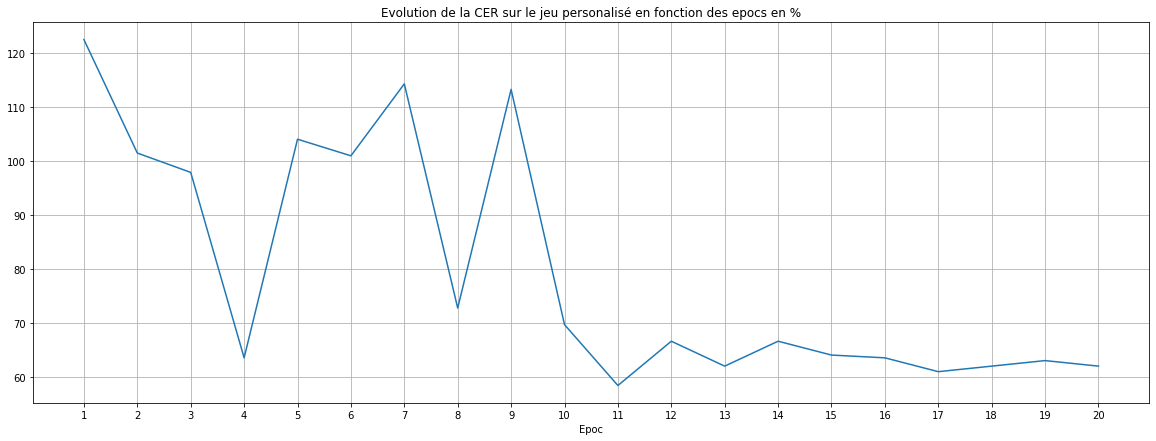

In [6]:
cer_test_list = []
epocs = np.arange(1,21)

for i in range(1,21):
    predictions = []
    model_name = './models/cnn_rnn_' + str(i)+ '.h5'
    m = tf.keras.models.load_model(model_name, compile=False) 
    for i in range(0, len(X)):
        predictions.append(greedy_decoder(m(tf.expand_dims([X_preprocessed[i]], -1)))[0])
    cer_test_list.append(fastwer.score(predictions, y, char_level=True))  

plt.figure(figsize=(20,7))
plt.xlabel('Epoc')
plt.title('Evolution de la CER sur le jeu personalisé en fonction des epocs en %')
plt.grid(True)
plt.xticks(epocs)
plt.plot(epocs, cer_test_list)

In [ ]:
dr = PymDrawingReader(model)
dr.show_widget()

In [164]:
# Resultats après 10 essai d'écriture du mot "hello"
pred_hello = ['hello','hello','haels','hallo','hello','hallo','hello','helo','hello','heleo']
truth_hello = ['hello','hello','hello','hello','hello','hello','hello','hello','hello','hello']
cer_hello = fastwer.score(pred_hello, truth_hello, char_level=True)
print(cer_hello)

14.0


In [165]:
# Resultats après 10 essai d'écriture du mot "datascience"
pred_ds = ['datesence','dascine','doneume','draaunce','dotaroanne','datasceane','sormmeence','datasence','dcderame','staoaine']
truth_ds = ['datascience','datascience','datascience','datascience','datascience','datascience','datascience','datascience','datascience','datascience']
cer_ds = fastwer.score(pred_ds, truth_ds, char_level=True)
print(cer_ds)

48.1818
